### Projet DESU 

**Objectif principal :** en s'appuyant sur les bases de données annuelles des accidents corporels de la circulation routière disponibles sur le site [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/#/resources), entrainer et tester un modèle de machine learning capable de **prédire si un accident de la route est létal ou non.** (<i>la variable à expliquer sera codée de la façon suivante : 1 = un décès ou plus ; 0 = aucun décès</i>)

**nb :** l'unité d'observation (ou unité statistique) est l'accident ('Num_Acc') et non l'usager.

**Objectifs secondaires :**
- des statistiques descriptives et des répresentations graphiques/géographiques pourront être réalisées pour décrire les données de manière explicite
- une fois opérationnel, le modèle de machine learning pourra être enrichi avec des données provenant d'autres sources (prix de l'essence, etc.)

--------------------------------
<i>D'après la documentation disponible sur [data.gouv.fr](https://www.data.gouv.fr/fr/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/#/resources), pour chaque accident corporel (soit un accident survenu sur une voie ouverte à la circulation publique, impliquant au moins un véhicule et ayant fait au moins une victime ayant nécessité des soins), des saisies d’information décrivant l’accident sont effectuées par l’unité des forces de l’ordre (police, gendarmerie, etc.) qui est intervenue sur le lieu de l’accident. Ces saisies sont rassemblées dans une fiche intitulée bulletin d’analyse des accidents corporels. L’ensemble de ces fiches constitue le fichier national des accidents corporels de la circulation dit « Fichier BAAC » administré par l’Observatoire national interministériel de la sécurité routière "ONISR".</i>

#### Étapes à suivre : 

**1.** Nettoyage des données : 
- suppression des valeurs manquantes ou aberrantes.
    
**2.** Sélection des variables et réencodage :
- conversion des variables catégorielles en variables numériques à l’aide de techniques telles que l’encodage one-hot.
- normalisation/standardisation des variables numériques.
- des fonctions d'aggrégation seront utilisées pour inclure les variables relatives aux usagers (évite la création de doublons).
- utilisation de techniques de sélection de caractéristiques (Analyse en composantes principales).
    
**3.** Fusion des dataframes sur 'Num_Acc'

**4.** Extraction de [X, y] pour entrainement et test du modèle de machine learning (régression logistique, XGBoost, Random Forest)
- construction d'un premier modèle de régression logistique avec la librairie scikit-learn
- test d'autres modèles avec AutoML



In [1]:
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

### Recodage de la variable à expliquer (y) :

In [2]:
#lecture des tables :
df_usagers_2021 = pd.read_csv("data/usagers-2021.csv", sep=';')
df_vehicules_2021 = pd.read_csv("data/vehicules-2021.csv", sep=';')
df_caracteristiques_2021 = pd.read_csv("data/caracteristiques-2021.csv", sep=';')
df_lieux_2021 = pd.read_csv("data/lieux-2021.csv", sep=';')

In [3]:
# créeation d'une nouvelle colonne 'deces' qui indique si l'usager a été tué ou non :
df_usagers_2021['deces'] = df_usagers_2021['grav'].apply(lambda x: 1 if x == 4 else 0)

In [4]:
# Regrouper les données par identifiant d'accident et compter le nombre de décès par accident
accidents = df_usagers_2021.groupby('Num_Acc')['deces'].sum().reset_index()

In [5]:
# Recoder la variable 'deces' en variable binaire
accidents['deces'] = accidents['deces'].apply(lambda x: 1 if x > 0 else 0)

In [6]:
#Pourcentage d'accidents ayant causé au moins 1 mort, pour les accidents survenus au cours de l'année 2021 :
accidents['deces'].value_counts(normalize=True)

1    0.717081
0    0.282919
Name: deces, dtype: float64

In [7]:
y = accidents.set_index('Num_Acc')

In [38]:
y = y['deces']

### Récupération des X depuis la table 'lieux' après nettoyage :

In [9]:
df_lieux_2021.isna().sum()/len(df_lieux_2021)

Num_Acc    0.000000
catr       0.000000
voie       0.077975
v1         0.000000
v2         0.911710
circ       0.000000
nbv        0.000000
vosp       0.000000
prof       0.000000
pr         0.000000
pr1        0.000000
plan       0.000000
lartpc     0.998089
larrout    0.000000
surf       0.000000
infra      0.000000
situ       0.000000
vma        0.000000
dtype: float64

<AxesSubplot:>

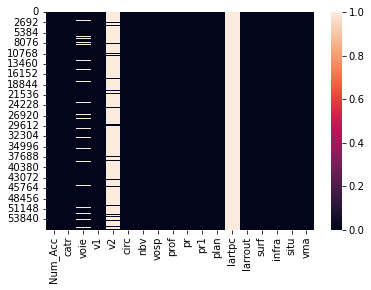

In [10]:
sns.heatmap(df_lieux_2021.isna())

In [11]:
df_lieux_cleaned = df_lieux_2021.replace(-1, np.nan)

In [12]:
df_lieux_cleaned = df_lieux_cleaned.replace(0, np.nan)

<AxesSubplot:>

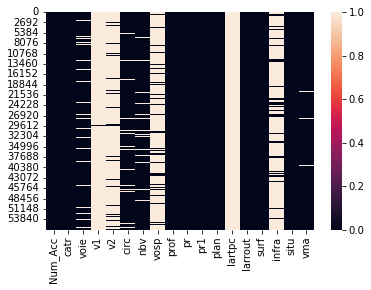

In [13]:
sns.heatmap(df_lieux_cleaned.isna())

In [14]:
df_lieux_cleaned = df_lieux_cleaned.drop(['voie', 'v1', 'v2', 'vosp', 'lartpc', 'infra', 'larrout'], axis=1)

In [15]:
df_lieux_cleaned = df_lieux_cleaned.replace('(1)', 1)

In [16]:
df_lieux_cleaned = df_lieux_cleaned.set_index('Num_Acc')

In [17]:
df_lieux_cleaned.surf.value_counts()

1.0    45481
2.0    10063
9.0      304
7.0      284
5.0      147
3.0       75
8.0       71
6.0       56
4.0       23
Name: surf, dtype: int64

In [18]:
df_vehicules_2021[['Num_Acc', 'obs']].head(50)

,Num_Acc,obs
0,202100000001,0
1,202100000001,0
2,202100000002,2
3,202100000002,0
4,202100000003,0
5,202100000004,0
6,202100000004,0
7,202100000005,0
8,202100000005,0
9,202100000006,0


In [19]:
df_carac_clean = df_caracteristiques_2021.set_index('Num_Acc').drop(["adr", "jour", "an", "lat", "long", "com", "hrmn","dep"],axis=1)

In [20]:
df_carac_clean

,mois,lum,agg,int,atm,col
Num_Acc,,,,,,
202100000001,11,2,1,1,1,1
202100000002,9,1,1,3,1,3
202100000003,7,1,2,1,7,6
202100000004,3,5,2,2,3,6
202100000005,2,5,2,1,1,2
...,...,...,...,...,...,...
202100056514,1,3,1,1,5,6
202100056515,1,1,1,1,2,6
202100056516,1,3,1,1,2,1


### Récupération des X depuis la table 'usagers' après nettoyage et aggrégation :

In [21]:
accidents = df_usagers_2021.groupby(['Num_Acc', 'sexe'])['sexe'].count().unstack().fillna(0)

In [22]:
accidents = accidents.drop([-1], axis=1)

In [23]:
accidents.columns = ['nb_femmes', 'nb_hommes']

In [24]:
accidents = accidents[['nb_femmes','nb_hommes']].astype(int)

In [45]:
r = accidents.merge(df_carac_clean, on='Num_Acc')

In [46]:
r

,nb_femmes,nb_hommes,mois,lum,agg,int,atm,col
Num_Acc,,,,,,,,
202100000001,2,0,11,2,1,1,1,1
202100000002,2,0,9,1,1,3,1,3
202100000003,1,1,7,1,2,1,7,6
202100000004,1,1,3,5,2,2,3,6
202100000005,0,1,2,5,2,1,1,2
...,...,...,...,...,...,...,...,...
202100056514,1,0,1,3,1,1,5,6
202100056515,1,0,1,1,1,1,2,6
202100056516,2,0,1,3,1,1,2,1


In [47]:
X = pd.get_dummies(r, columns=['lum', 'agg', 'int', 'atm', 'col'])

In [48]:
X

,nb_femmes,nb_hommes,mois,lum_1,lum_2,lum_3,lum_4,lum_5,agg_1,agg_2,...,atm_8,atm_9,col_-1,col_1,col_2,col_3,col_4,col_5,col_6,col_7
Num_Acc,,,,,,,,,,,,,,,,,,,,,
202100000001,2,0,11,0,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
202100000002,2,0,9,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
202100000003,1,1,7,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
202100000004,1,1,3,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,0
202100000005,0,1,2,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202100056514,1,0,1,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
202100056515,1,0,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
202100056516,2,0,1,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


### Utilisation d'un modele K-Neighbors Classifier :

In [49]:
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state=random.seed())

In [50]:
print(X_train.shape)
print(X_test.shape)

(39562, 37)
(16956, 37)


In [51]:
n_neighbors=9
model = neighbors.KNeighborsClassifier(n_neighbors) # je précise la méthode et ses hyperparamètres
model.fit(X_train, Y_train) # je lance l'apprentissage
prev_test = model.predict(X_test)
sc_train = model.score(X_train,Y_train)
sc_test = model.score(X_test,Y_test)
print(sc_train)
print(sc_test)

0.752540316465295
0.721927341354093


In [52]:
cm = confusion_matrix(Y_test,prev_test)
print(cm)

[[ 1355  3418]
 [ 1297 10886]]


In [ ]:
kf=KFold(n_splits=3, shuffle=True) # partages de validation

scores=[]

for k in range(1,10):  # les différentes valeurs de k à tester
    score=0
    clf=neighbors.KNeighborsClassifier(k)
    for learn,test in kf.split(X_train): # boucle sur différents partages de validation
        X_app=X_train.iloc[learn]
        Y_app=Y_train.iloc[learn]
        clf.fit(X_app,Y_app)
        X_val=X_train.iloc[test]
        Y_val=Y_train.iloc[test]
        score+=clf.score(X_val,Y_val)
    scores.append(score)
    
print(scores)
#plt(scores)
k_opt=scores.index(max(scores)) + 1  # valeur optimale de k
print(k_opt)

In [ ]:
# Fusion des dataframes originaux
#data = pd.merge(df_caracteristiques_2021, df_lieux_2021, on='Num_Acc')
#data = pd.merge(data, df_vehicules_2021, on='Num_Acc')
#data = pd.merge(data, df_usagers_2021, on=['Num_Acc', 'num_veh'])

# Sélectionner les variables d'intérêt
#data = data[['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'lartpc', 'larrout', 'senc', 'catv', 'occutc', 'obs', 'place', 'catu', 'sexe', 'trajet']]

# Encoder les variables catégorielles
#data = pd.get_dummies(data, columns=['lum', 'agg', 'int', 'atm', 'col', 'catr', 'circ', 'vosp', 'prof', 'plan', 'senc', 'catv', 'obs', 'place', 'catu', 'sexe', 'trajet'])

# Créer des caractéristiques d'interaction
#data['lartpc_lum'] = data['lartpc'] * data['lum_3']